In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
df_full = pd.read_csv("processed-data/processed_2023_qc.csv")
df_full["date"] = pd.to_datetime(df_full["date"])

## Checking the quality of data

***QC test categories:***

G - Good


F - Too many minutely flags failed QC


M - Missing too many time-steps

In [85]:
df_qc = df_full.loc[:, ["date", "time"] + df_full.columns[df_full.columns.str.startswith("qcscore")].tolist()]
qc_list = [col for col in df_qc.columns if col not in ["date", "time"]]
(df_qc[qc_list].apply(pd.Series.value_counts).fillna(0)
                                             .astype(int)
                                             .sort_values(by="qcscore", ascending=False))

,qcscore,qcscore_maxt,qcscore_mint,qcscore_rh,qcscore_ws,qcscore_wd,qcscore_60rf,qcscore_sol
G,8755,8760,8760,8760,8760,5556,8759,8709
F,5,0,0,0,0,0,0,51
M,0,0,0,0,0,3025,1,0


In [86]:
df = df_full[["date", 
              "time", 
              "Air Temperature in degree C", 
              "Minimum Air Temperature in degree C", 
              "Maximum Air Temperature in degree C",
              "Relative Humidity in %",
              "Wind Speed in km/hr",
              "Wind Direction", 
              "Past 60-Minutes Rainfall in mm", 
              "Solar Radiation in W/m^2"]]

df = df.rename(columns={"Air Temperature in degree C": "temp(c)",
                        "Minimum Air Temperature in degree C": "min_temp(c)",
                        "Maximum Air Temperature in degree C": "max_temp(c)",
                        "Relative Humidity in %": "rel_humid(%)",
                        "Wind Speed in km/hr": "wind_speed(km/hr)",
                        "Wind Direction": "wind_dir",
                        "Past 60-Minutes Rainfall in mm": "rainfall(mm)",
                        "Solar Radiation in W/m^2": "sol_rad(W/m^2)"})

df.head(5)

,date,time,temp(c),min_temp(c),max_temp(c),rel_humid(%),wind_speed(km/hr),wind_dir,rainfall(mm),sol_rad(W/m^2)
0,2023-01-01,00:00:00,16.0,12.3,19.8,76.5,2.9,9.8,0.0,0.0
1,2023-01-01,01:00:00,16.0,16.0,16.1,76.8,3.1,12.2,0.0,0.0
2,2023-01-01,02:00:00,15.7,15.7,16.1,76.6,3.8,11.1,0.0,0.0
3,2023-01-01,03:00:00,15.2,15.2,16.1,78.5,3.3,8.5,0.0,0.0
4,2023-01-01,04:00:00,15.0,15.0,16.1,79.5,3.7,12.6,0.0,0.0


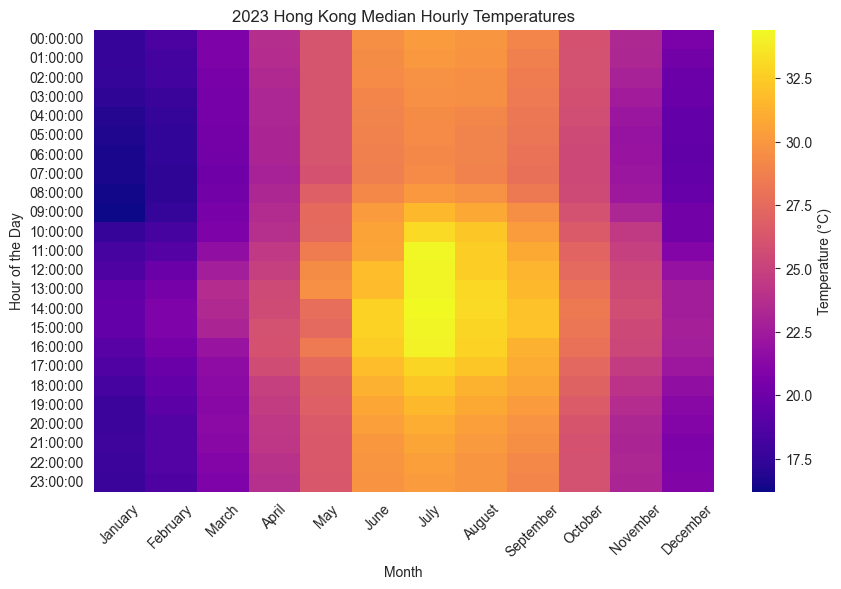

In [126]:
# Plot a heatmap of the median hourly temperature distribution across the whole year
df_temp = df[["date", "time", "temp(c)"]].copy()
df_temp["month"] = df["date"].dt.strftime("%B")
df_temp["month_num"] = df["date"].dt.month
df_temp = df_temp.drop(columns={"date"})
df_avg_hr_temp_year = (df_temp.groupby(["time", "month"])
                              .aggregate("median")
                              .sort_values(by=["month_num", "time"])
                              .reset_index())

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

df_avg_hr_temp_year["month"] = pd.Categorical(df_avg_hr_temp_year["month"], 
                                              categories=month_order, 
                                              ordered=True)

heatmap_data = df_avg_hr_temp_year.pivot(index="time", 
                                         columns="month", 
                                         values="temp(c)")

# Plot the heatmap
plt.figure(figsize=(10, 6))

sns.heatmap(heatmap_data, 
            annot=False, 
            cmap="plasma", 
            cbar_kws={"label": "Temperature (°C)"})

plt.xticks(rotation=45)
plt.title("2023 Hong Kong Median Hourly Temperatures")
plt.ylabel("Hour of the Day")
plt.xlabel("Month")
plt.savefig("output-graphs/hourly_year_temp.png")
plt.show()

In [123]:
df

month,January,February,March,April,May,June,July,August,September,October,November,December
time,,,,,,,,,,,,
00:00:00,17.6,18.50,20.7,23.70,26.1,29.5,30.2,29.9,29.00,26.0,23.35,20.6
01:00:00,17.6,18.15,20.7,23.65,26.1,29.4,30.0,29.8,28.75,25.9,23.30,20.2
02:00:00,17.5,18.05,20.5,23.40,26.1,29.3,29.7,29.5,28.55,25.9,22.95,19.9
03:00:00,17.3,17.70,20.4,23.20,26.1,29.0,29.6,29.5,28.40,25.8,22.55,19.8
04:00:00,16.9,17.50,20.4,23.20,26.1,28.9,29.4,29.1,28.25,25.7,22.20,19.6
